### Physics Informed Neural Operator (PINO): Solving a ODE for different right hand sides
In this notebook, we present an introduction to the PINO concept in TorchPhysics. 
As an example, we try to learn the integral operator of the ODE:
\begin{align*}
    \partial_t u(t) &= f(t), \text{ in } [0, 1] \\
    u(0) &= 0
\end{align*}
for different functions $f$. Since this a physics informed approach no data is requiered.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5" # select GPUs to use

import torch 
import torchphysics as tp
import pytorch_lightning as pl

In [2]:
T = tp.spaces.R1("t")
F = tp.spaces.R1("f")
U = tp.spaces.R1("u")

input_fn_space = tp.spaces.FunctionSpace(T, F)

In [3]:
hidden_channels = 16

model = tp.models.FNO(F, U, 
                      fourier_layers=5, 
                      hidden_channels=hidden_channels, 
                      fourier_modes=8, 
                      skip_connections=True, 
                      channel_up_sample_network=torch.nn.Sequential(
                          torch.nn.Linear(F.dim, hidden_channels),
                          torch.nn.Tanh(),
                          torch.nn.Linear(hidden_channels, hidden_channels),
                          torch.nn.Tanh(),
                          torch.nn.Linear(hidden_channels, hidden_channels)
                      ),
                      channel_down_sample_network=torch.nn.Sequential(
                          torch.nn.Linear(hidden_channels, hidden_channels),
                          torch.nn.Tanh(),
                          torch.nn.Linear(hidden_channels, hidden_channels),
                          torch.nn.Tanh(),
                          torch.nn.Linear(hidden_channels, U.dim)
                      ),
                      space_resolution=100)

In [4]:
N_time = 100
time_grid = torch.linspace(0, 1, N_time).reshape(1, -1, 1)
step_size = time_grid[0, 1, 0] - time_grid[0, 0, 0]
time_grid_points = tp.spaces.Points(time_grid, T)

In [5]:
harmonic_fn_set = tp.domains.HarmonicFunctionSet1D(
    input_fn_space, 
    function_set_size=50000, 
    period=1.0, 
    max_frequence=4
)

discrete_harmonic_fn_set = harmonic_fn_set.discretize(time_grid_points)

fn_sampler = tp.samplers.FunctionSamplerRandomUniform(10000, discrete_harmonic_fn_set, 100)

In [6]:
def ode_residual(u, f):
    u_t = tp.utils.discrete_grad_on_grid(u, grid_size=step_size)
    return u_t - f

ode_condition = tp.conditions.PIOperatorCondition(module=model, 
                                        input_function_sampler=fn_sampler, 
                                        residual_fn=ode_residual, 
                                        weight=0.1)

In [7]:
def initial_residual(u):
    return u[:, 0]

initial_condition = tp.conditions.PIOperatorCondition(module=model, 
                                        input_function_sampler=fn_sampler, 
                                        residual_fn=initial_residual, 
                                        weight=100.0)

In [8]:
lr_list = [0.001, 0.0001, 0.00005]
step_list = [2000, 2500, 2500]

for i in range(len(lr_list)):
    optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=lr_list[i])
    solver = tp.solver.Solver([ode_condition, initial_condition], optimizer_setting=optim)

    trainer = pl.Trainer(devices=1, accelerator="gpu",
                        num_sanity_val_steps=0,
                        benchmark=True,
                        max_steps=step_list[i], 
                        logger=False, 
                        enable_checkpointing=False)

    trainer.fit(solver)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [5]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 4.1 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.017     Total estimated model params size (MB)
/home/tomfre/miniconda3/envs/tp_version2/lib/python3.11/site-packages/pytorch_lightning/tra

Epoch 0: 100%|██████████| 2000/2000 [03:55<00:00,  8.50it/s, train/loss=0.613]

`Trainer.fit` stopped: `max_steps=2000` reached.


Epoch 0: 100%|██████████| 2000/2000 [03:55<00:00,  8.50it/s, train/loss=0.613]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [5]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 4.1 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.017     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 2500/2500 [04:52<00:00,  8.54it/s, train/loss=0.183]

`Trainer.fit` stopped: `max_steps=2500` reached.


Epoch 0: 100%|██████████| 2500/2500 [04:52<00:00,  8.54it/s, train/loss=0.183]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [5]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 4.1 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.017     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 2500/2500 [04:52<00:00,  8.56it/s, train/loss=0.117]

`Trainer.fit` stopped: `max_steps=2500` reached.


Epoch 0: 100%|██████████| 2500/2500 [04:52<00:00,  8.56it/s, train/loss=0.117]


In [9]:
N_test = 1000
discrete_harmonic_fn_set.create_functions()
test_fns = discrete_harmonic_fn_set.get_function(torch.arange(N_test))

model_out = model(test_fns).as_tensor

output_data_test = torch.zeros((N_test, N_time, 1))
test_fns = test_fns.as_tensor
for i in range(1, N_time):
    output_data_test[:, i, 0] = output_data_test[:, i-1, 0] + step_size * test_fns[:, i, 0]

print("Max error:", torch.max(torch.abs(output_data_test - model_out)).detach().item())
rel_error = 100.0 * torch.max(torch.abs(output_data_test - model_out))/torch.max(torch.abs(output_data_test))
print("Rel. error:", rel_error.detach().item(), "%")

Max error: 0.22796916961669922
Rel. error: 7.81789493560791 %


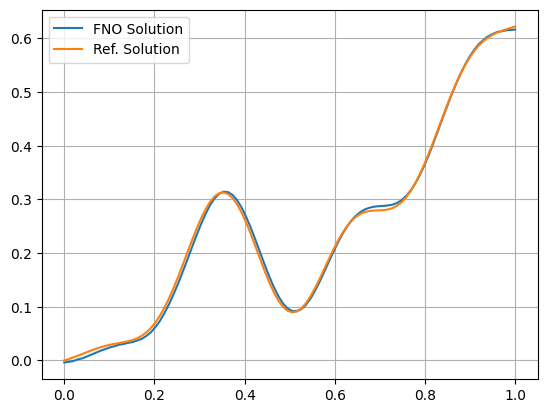

In [16]:
import matplotlib.pyplot as plt

example_plot = 142
t = torch.linspace(0, 1, N_time)
plt.plot(time_grid[0], model_out[example_plot].detach().cpu())
plt.plot(time_grid[0], output_data_test[example_plot].detach().cpu())
plt.legend(["FNO Solution", "Ref. Solution"])
plt.grid()